## Niklas Bloom

#### Data: 
daily prices and volumes of selected spdr etfs.

#### Goal: 
To apply machine learning techniques to recommend a Sector ETF that is likely to be in the 50th percentile next-day returns. This involves predicting whether a given ETF will perform better than the median return of the group.

#### How: 
Select an "TICKER_OF_INTEREST". For this ticker, we will calculate how often it is above the 50th percentile for returns (returns calculated as % change from previous day). Data is plotted, features are added, and data is split into training and testing data. I use three different sub-models, SVM(Support Vector Machine), random forest, and XGBoost. The predictions from these sub-models are then fed into a stacked neural network which takes these predictions to generate a final recommendation on the ETF likely to exceed the 50th percentile in next-day returns. 

In the post-analysis the project involves calculating the predicted returns for the chosen "TICKER_OF_INTEREST" based on the stacked model's predictions. For each date where the model predicts the ETF to be above the 50th percentile, the corresponding forward returns are accumulated and averaged to estimate the mean predicted returns. Additionally, the mean returns for each ticker in the dataset are computed over the testing period to provide a comparative overview of performance across different ETFs.

#### Usefulness:

Historical Data Analysis: While the code doesn’t forecast future returns, it does analyze historical data to identify patterns. This analysis can be useful for backtesting investment strategies or for educational purposes to understand how different factors might influence ETF performance.

Investment Strategy Development: Investors might use this type of analysis as part of a broader investment strategy. For example, understanding which ETFs frequently perform in the top 50th percentile could inform decisions about portfolio diversification or risk management.


#### Notes: 
The SMA(simple moving average) and EMA(exponential moving averages) are features I added to the data. Its purpose is to help the machine learning model achieve more accurate results and they provide insights into the ETFs' trends and momentum, which are critical factors in financial time-series analysis.

#### Future: 
Given more time, the analysis could be expanded by including additional features such as ARIMA (AutoRegressive Integrated Moving Average) and Fast Fourier Transform for more sophisticated trend and periodicity analysis. Enhancing the visualization of the results could also provide clearer insights and make the findings more accessible.

#### Beware: 
A significant consideration in using this model is the risk of overfitting, which is where the model performs exceptionally well on the training data but poorly on unseen data. It is crucial to test the model across different economic periods and conduct thorough out-of-sample testing to ensure its robustness and reliability in various market conditions.

In [1]:

#Dependencies
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import datetime
import statsmodels 

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import cvxpy as cp
import yfinance as yf




import warnings
warnings.filterwarnings("ignore")
     

In [2]:
# Input Sector ETF Tickers
tickers = ['XLP', 'XLY', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU']
PERCENTILE = 50
#User input
TICKER_OF_INTEREST = 'XLP'

In [3]:
# Input dates
startdate = datetime.datetime(1999, 3, 31)
enddate = datetime.datetime(2023, 11, 21)


#Extra data for Arima model
arima_startdate = datetime.datetime(1998, 12, 17)
arima_enddate = datetime.datetime(1999, 3, 30)

#Extra data
extra_startdate = datetime.datetime(1998, 12, 18)
extra_enddate =  datetime.datetime(1999, 3, 30)

In [4]:
# Retrieve prices and volumes
prices_dict = {}
volumes_dict = {}

for ticker in tickers:
    ticker_data = yf.download(ticker, start=startdate, end=enddate)
    prices_dict[ticker] = ticker_data['Adj Close']
    volumes_dict[ticker] = ticker_data['Volume']

# Convert to DataFrame
prices = pd.DataFrame(prices_dict)
volumes = pd.DataFrame(volumes_dict)

# Calculate Returns
returns = prices.pct_change().dropna()
volumes


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,XLP,XLY,XLE,XLF,XLV,XLI,XLB,XLK,XLU
Date,,,,,,,,,
1999-03-31,45800,24400,67000,112637,6300,21700,10600,774700,20500
1999-04-01,38500,4100,22000,52933,22500,3500,12300,318500,11200
1999-04-05,32900,9600,58400,92941,12400,7700,11900,1003500,8400
1999-04-06,136600,10900,42600,142427,14500,2700,52800,540100,38900
1999-04-07,77800,13600,836400,324738,15700,24400,45200,931700,29100
...,...,...,...,...,...,...,...,...,...
2023-11-14,13606200,7629200,17362000,54296300,11216900,12873000,5497900,8254200,28659100
2023-11-15,10618900,6194400,16521800,35000200,9262700,8516300,4909900,6573900,24831400
2023-11-16,16536300,6143700,26583000,33222500,7665900,8611100,3582800,5776800,17325200


In [5]:
returns

,XLP,XLY,XLE,XLF,XLV,XLI,XLB,XLK,XLU
Date,,,,,,,,,
1999-04-01,0.001773,-0.001093,-0.001271,0.002506,0.000000,0.010651,0.011495,0.015799,0.021077
1999-04-05,0.005310,0.013130,0.024173,0.020000,0.022322,0.021699,0.012074,0.034468,0.008028
1999-04-06,-0.011150,0.005399,-0.009938,-0.007353,0.001092,-0.005462,-0.017544,0.008533,-0.005119
1999-04-07,-0.001186,0.008593,-0.010038,0.027160,0.019084,0.001830,0.010715,-0.002418,0.013150
1999-04-08,0.023172,0.022364,0.010139,0.018029,0.010166,0.005482,0.014134,0.009693,0.026523
...,...,...,...,...,...,...,...,...,...
2023-11-14,0.010263,0.033685,0.008928,0.018901,0.006772,0.020070,0.029515,0.020003,0.039933
2023-11-15,0.008013,0.001194,-0.001888,0.005507,0.000782,0.002101,0.004401,0.001264,-0.003065
2023-11-16,-0.012349,-0.010253,-0.019504,0.004036,0.004298,0.000191,0.003005,0.004993,0.005341


<Axes: xlabel='Date'>

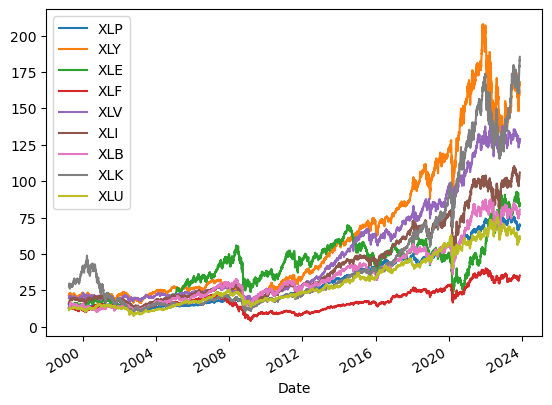

In [6]:
prices.plot()

<Axes: xlabel='Date'>

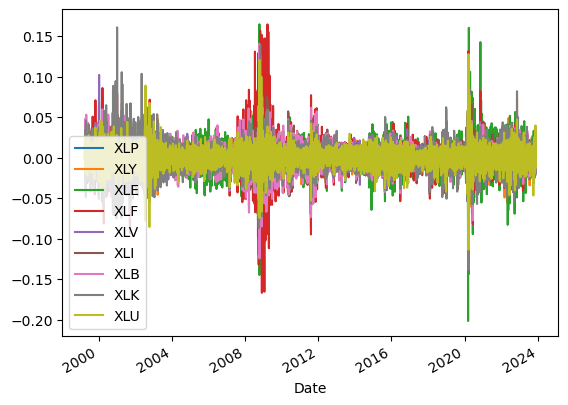

In [7]:
returns.plot()

<Axes: xlabel='Date'>

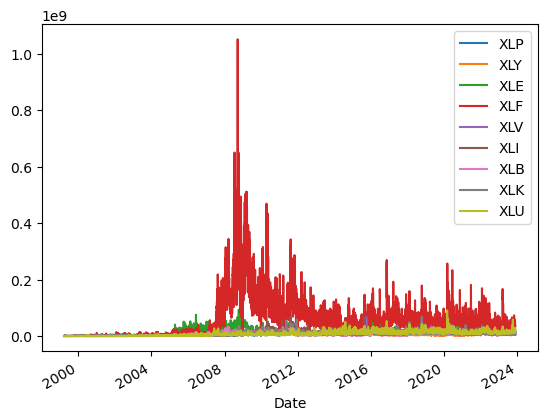

In [8]:
volumes.plot()

In [9]:
#Create DF

from sklearn.preprocessing import LabelEncoder

df = returns.copy()
df.columns = [str(col) + '_returns' for col in df.columns]

#what if there are >1 max?
max_next_day = df.idxmax(axis = 1)

df["max_next_day"] = max_next_day
df.max_next_day = df.max_next_day.shift(-1)

df.drop(df.tail(1).index,inplace=True) #remove last row

le = LabelEncoder()
df['labelencode_max_next_day'] = le.fit_transform(df['max_next_day'])

df.head()

,XLP_returns,XLY_returns,XLE_returns,XLF_returns,XLV_returns,XLI_returns,XLB_returns,XLK_returns,XLU_returns,max_next_day,labelencode_max_next_day
Date,,,,,,,,,,,
1999-04-01,0.001773,-0.001093,-0.001271,0.002506,0.000000,0.010651,0.011495,0.015799,0.021077,XLK_returns,4
1999-04-05,0.005310,0.013130,0.024173,0.020000,0.022322,0.021699,0.012074,0.034468,0.008028,XLK_returns,4
1999-04-06,-0.011150,0.005399,-0.009938,-0.007353,0.001092,-0.005462,-0.017544,0.008533,-0.005119,XLF_returns,2
1999-04-07,-0.001186,0.008593,-0.010038,0.027160,0.019084,0.001830,0.010715,-0.002418,0.013150,XLU_returns,6
1999-04-08,0.023172,0.022364,0.010139,0.018029,0.010166,0.005482,0.014134,0.009693,0.026523,XLE_returns,1


In [10]:

#Add Volume into DF
#Removed first and last
for ticker in tickers:
    df[ticker+'_vol'] = volumes[ticker][1:-1]


In [11]:
#Add forward-looking next day's returns (Thais column will not be used for training. Only for post-analysis)

look_forward_returns = returns.copy().iloc[1:,:]
df_forward_returns = pd.DataFrame(index= df.index.tolist())

for ticker in tickers:
    look_forward_returns_list = look_forward_returns[ticker].tolist()
    df_forward_returns[ticker+'_1D_forward_returns'] = look_forward_returns_list

In [12]:
#Create Desired output column
#Renames columns

returns_temp = returns.copy()
returns_temp.columns = [str(col) + '_returns' for col in returns_temp.columns]
returns_temp[str(PERCENTILE) + ' Percentile'] = returns_temp.quantile(q=PERCENTILE/100,axis=1)
returns_temp['>' + str(PERCENTILE) + ' Percentile?'] = np.where(returns_temp[TICKER_OF_INTEREST + '_returns'] >= returns_temp[str(PERCENTILE) + ' Percentile'], 1, 0)

returns_temp.drop(returns_temp.tail(1).index,inplace=True)
df = pd.concat([df, returns_temp], axis=1, join='inner')

df = df.loc[:,~df.columns.duplicated()]





# Initial Analysis #

In [13]:
#Composition of Desired output in dataset
df['>' + str(PERCENTILE) + ' Percentile?'].value_counts()


>50 Percentile?
1    3449
0    2751
Name: count, dtype: int64

In [14]:
#Check average daily returns
print(returns.mean(axis=0))


XLP    0.000295
XLY    0.000435
XLE    0.000471
XLF    0.000337
XLV    0.000369
XLI    0.000396
XLB    0.000415
XLK    0.000440
XLU    0.000350
dtype: float64


In [15]:
#Days where the % Change in returns is zero
zero_counts = (returns == 0).sum()
print(zero_counts)



XLP    123
XLY     63
XLE     44
XLF     91
XLV     83
XLI     63
XLB     68
XLK     73
XLU     78
dtype: int64


In [16]:
#Sector with Highest Returns
max_sector = returns.mean().idxmax()
max_value = returns.mean().max()
print("\nSector with Highest Returns: " + max_sector + ", Average Return: " + str(max_value))




Sector with Highest Returns: XLE, Average Return: 0.00047081029661682024


In [17]:
    
#Composition of Dataset
for ticker in returns.columns:
    print("% of Dataset max_next_day_return that is " + ticker + ": " + str(len(df[df["max_next_day"] == ticker+"_returns"])/len(df)))

% of Dataset max_next_day_return that is XLP: 0.08483870967741935
% of Dataset max_next_day_return that is XLY: 0.07967741935483871
% of Dataset max_next_day_return that is XLE: 0.21306451612903227
% of Dataset max_next_day_return that is XLF: 0.10483870967741936
% of Dataset max_next_day_return that is XLV: 0.08387096774193549
% of Dataset max_next_day_return that is XLI: 0.04806451612903226
% of Dataset max_next_day_return that is XLB: 0.1
% of Dataset max_next_day_return that is XLK: 0.1267741935483871
% of Dataset max_next_day_return that is XLU: 0.1588709677419355


# Feature Engineering#

## Simple Moving Averages

In [18]:
#Add Additional training data
extra_prices_dict = {}
for ticker in tickers:
    extra_ticker_prices = yf.download(ticker, start=extra_startdate, end=enddate)
    extra_prices_dict[ticker] = extra_ticker_prices['Adj Close']
    #In for loop assigns

extra_prices = pd.DataFrame(extra_prices_dict)


extra_prices.tail()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,XLP,XLY,XLE,XLF,XLV,XLI,XLB,XLK,XLU
Date,,,,,,,,,
2023-11-14,69.889999,167.550003,84.760002,34.500000,127.860001,104.699997,79.529999,182.039993,61.980000
2023-11-15,70.449997,167.750000,84.599998,34.689999,127.959999,104.919998,79.879997,182.270004,61.790001
2023-11-16,69.580002,166.029999,82.949997,34.830002,128.509995,104.940002,80.120003,183.179993,62.119999
2023-11-17,69.489998,167.139999,84.690002,35.009998,128.250000,105.610001,80.269997,182.800003,62.290001
2023-11-20,69.440002,168.000000,84.809998,35.150002,129.029999,105.930000,80.410004,185.449997,62.099998


In [19]:
#extra_prices = extra_prices.reindex(df.index, method='nearest')

#Simple Moving Average Analysis
for ticker in tickers:
    # Calculate rolling means
    extra_prices[ticker + '_rolling_mean20'] = extra_prices[ticker].rolling(window=20).mean()
    extra_prices[ticker + '_rolling_mean50'] = extra_prices[ticker].rolling(window=50).mean()
    
    

extra_prices.tail()

  

,XLP,XLY,XLE,XLF,XLV,XLI,XLB,XLK,XLU,XLP_rolling_mean20,...,XLV_rolling_mean20,XLV_rolling_mean50,XLI_rolling_mean20,XLI_rolling_mean50,XLB_rolling_mean20,XLB_rolling_mean50,XLK_rolling_mean20,XLK_rolling_mean50,XLU_rolling_mean20,XLU_rolling_mean50
Date,,,,,,,,,,,,,,,,,,,,,
2023-11-14,69.889999,167.550003,84.760002,34.500000,127.860001,104.699997,79.529999,182.039993,61.980000,68.1775,...,126.754501,129.001431,99.9725,101.692280,76.503500,78.213501,169.332999,168.518721,59.9325,60.445167
2023-11-15,70.449997,167.750000,84.599998,34.689999,127.959999,104.919998,79.879997,182.270004,61.790001,68.2985,...,126.660001,128.941972,100.1855,101.669123,76.641500,78.177178,170.060499,168.672380,60.0605,60.454505
2023-11-16,69.580002,166.029999,82.949997,34.830002,128.509995,104.940002,80.120003,183.179993,62.119999,68.4010,...,126.657000,128.881761,100.4460,101.653337,76.836500,78.153019,170.881499,168.894730,60.2345,60.454374
2023-11-17,69.489998,167.139999,84.690002,35.009998,128.250000,105.610001,80.269997,182.800003,62.290001,68.5120,...,126.666500,128.816351,100.7915,101.661508,77.084999,78.130267,171.824499,169.102296,60.4475,60.446731
2023-11-20,69.440002,168.000000,84.809998,35.150002,129.029999,105.930000,80.410004,185.449997,62.099998,68.6270,...,126.755000,128.748414,101.1760,101.675482,77.382500,78.103350,172.890498,169.344901,60.6755,60.430130


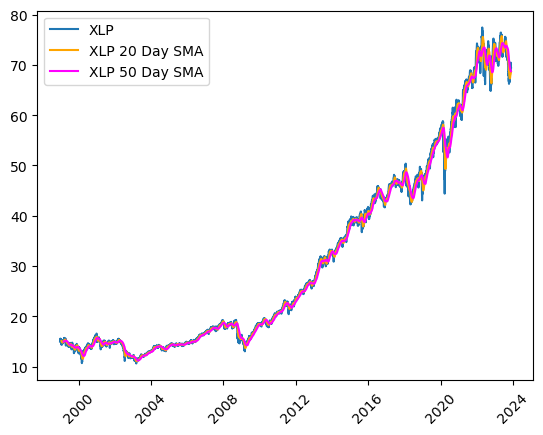

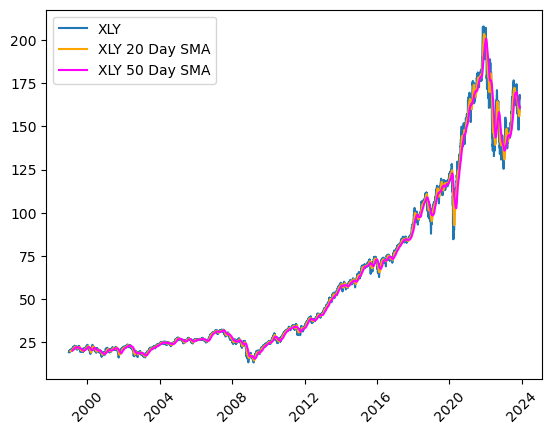

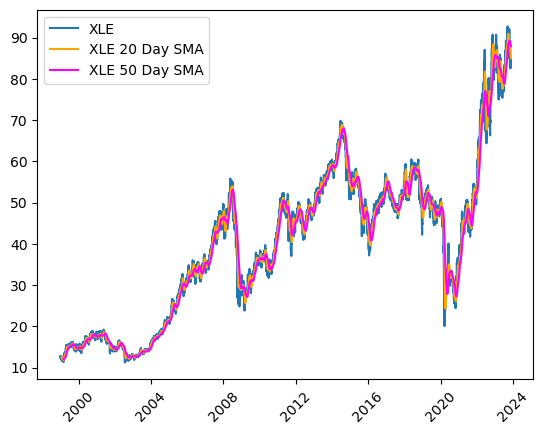

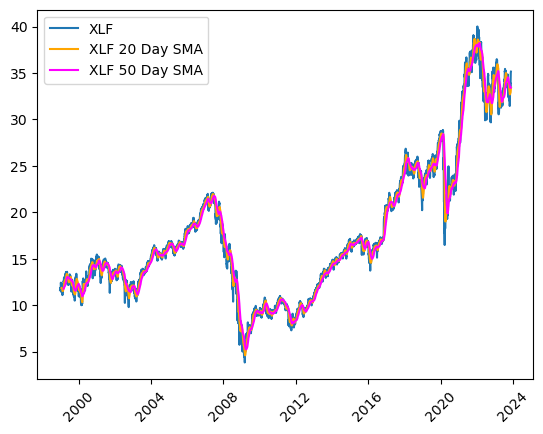

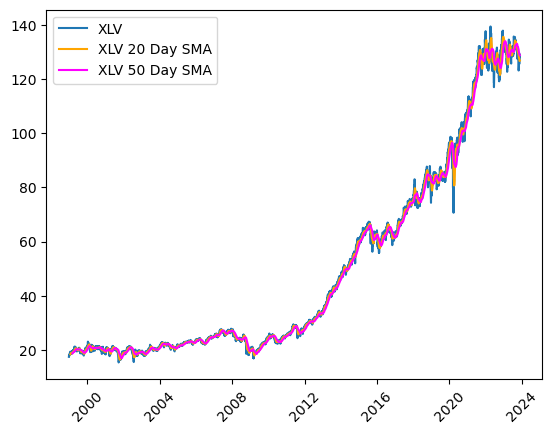

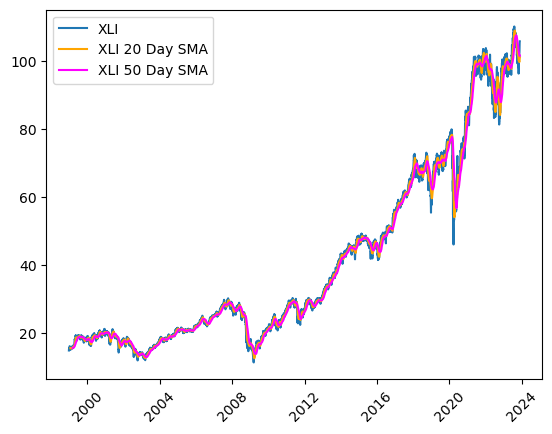

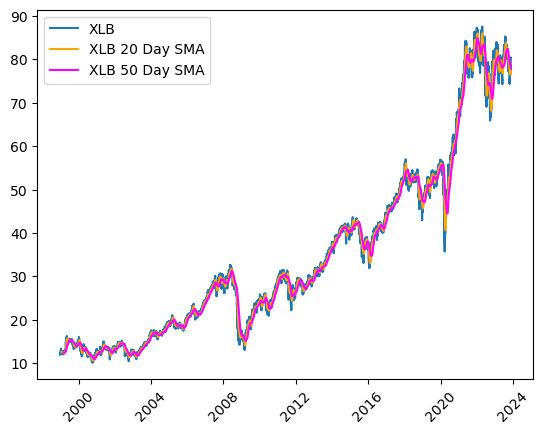

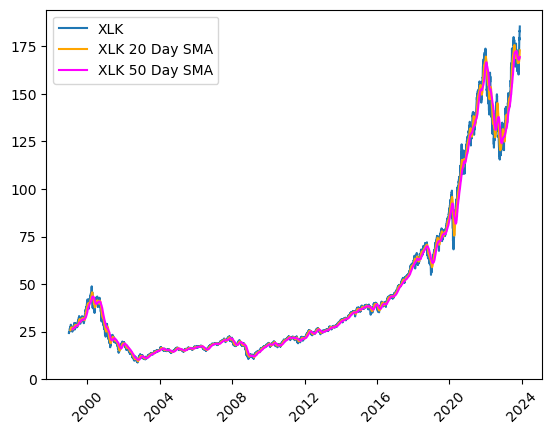

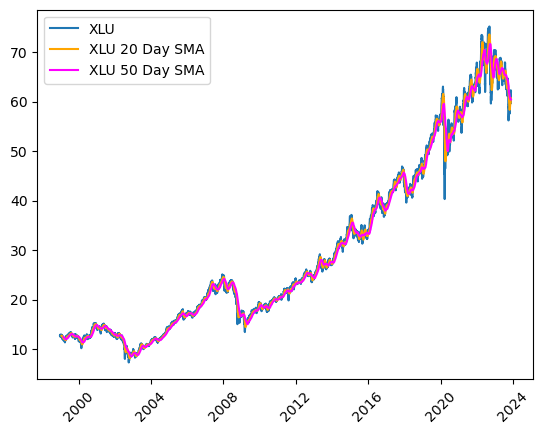

In [20]:
for ticker in tickers:
    # Assign values to df using the aligned indices
    df[ticker + '_rolling_mean'] = extra_prices[ticker + '_rolling_mean20'][df.index.values]
    df[ticker + '_rolling_mean50'] = extra_prices[ticker + '_rolling_mean50'][df.index.values]
    df[ticker + '_rolling_mean_difference'] = df[ticker + '_rolling_mean'] - df[ticker + '_rolling_mean50']
    
    # Plotting - here, ensure you use 'extra_prices' instead of 'prices'
    #Simple Moving Average Analysis
    plt.plot(extra_prices[ticker], label=ticker)
    plt.plot(extra_prices[ticker + '_rolling_mean20'], label= ticker + ' 20 Day SMA', color='orange')
    plt.plot(extra_prices[ticker + '_rolling_mean50'], label= ticker + ' 50 Day SMA', color='magenta')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
print(df.size())

## Exponential Moving Averages

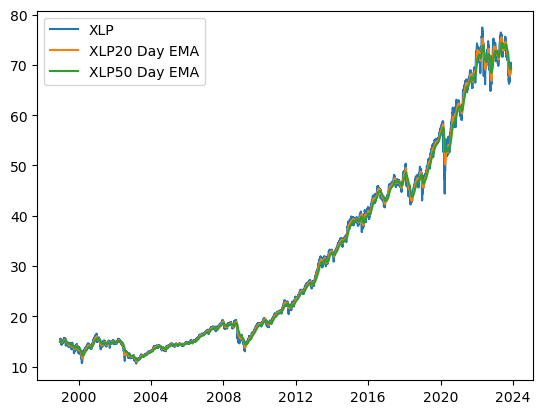

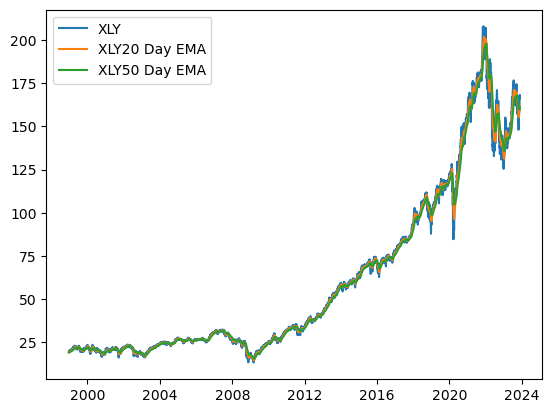

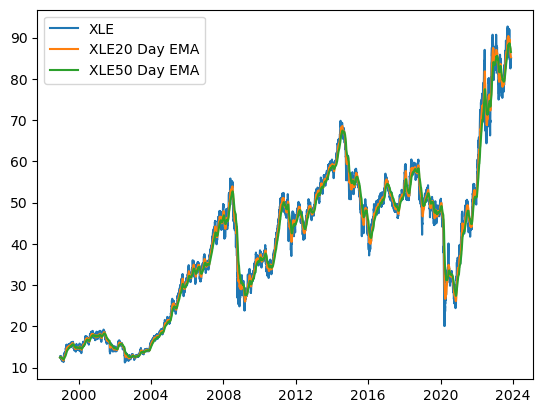

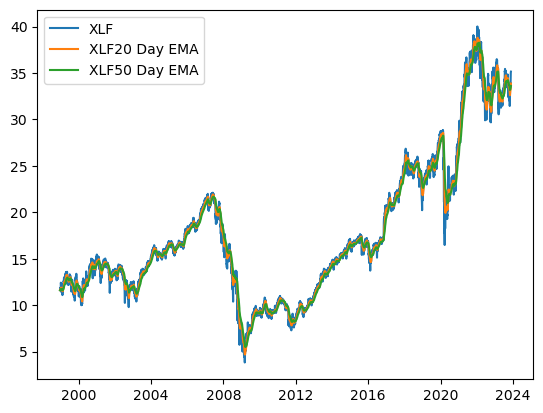

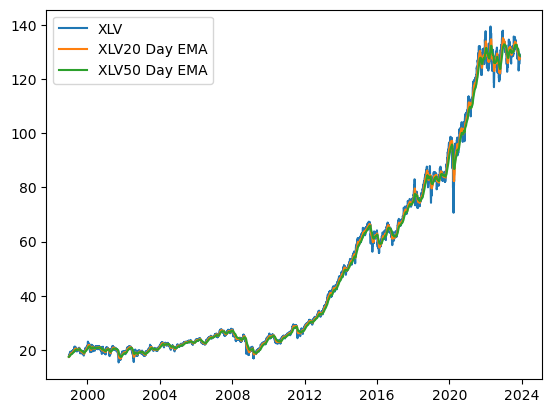

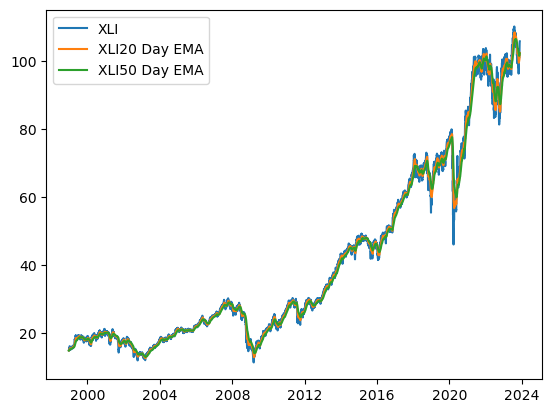

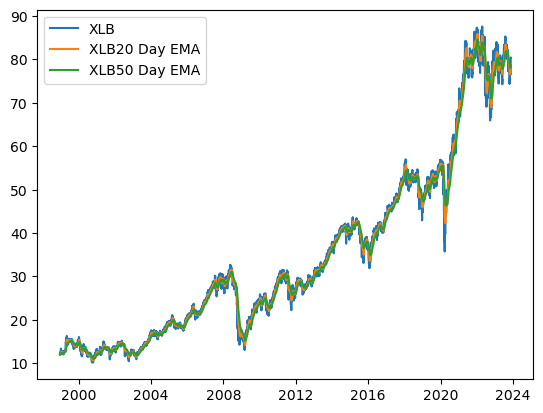

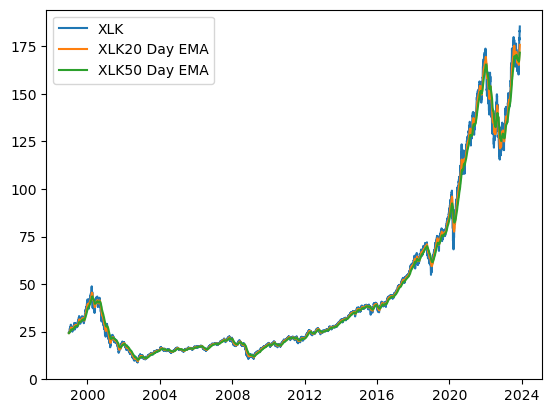

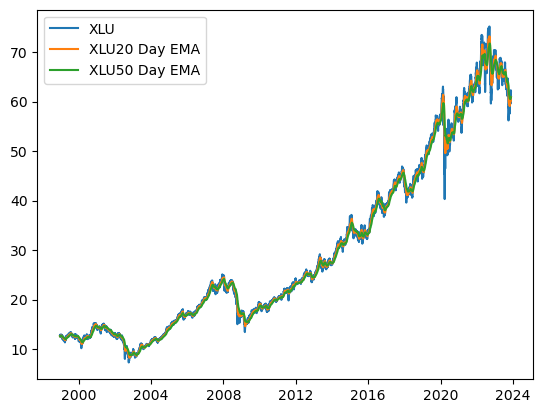

In [22]:
#TEST 1
for ticker in tickers:
    extra_prices[ticker + '_exp20'] = extra_prices[ticker].ewm(span=20, adjust=False).mean()
    extra_prices[ticker + '_exp50'] = extra_prices[ticker].ewm(span=50, adjust=False).mean()
    df[ticker + '_exp20'] = extra_prices[ticker + '_exp20'][df.index.values]
    df[ticker + '_exp50'] = extra_prices[ticker + '_exp50'][df.index.values]
    df[ticker + '_exp_difference'] = df[ticker + '_exp20'] - df[ticker + '_exp50']
    #print(df.tail())
    
    plt.plot(extra_prices[ticker], label=ticker)
    plt.plot(extra_prices[ticker + '_exp20'], label=ticker + '20 Day EMA')
    plt.plot(extra_prices[ticker + '_exp50'], label=ticker + '50 Day EMA')
    plt.legend(loc='upper left')
    plt.show()

## Data Preprocessing

In [23]:
#create x and y for our data training and testing
x = df.drop(['max_next_day', 'labelencode_max_next_day','>' + str(PERCENTILE) + ' Percentile?'], axis=1).copy() #making copies so editing x & y wouldnt change df
y = df['>' + str(PERCENTILE) + ' Percentile?'].copy()

#Change to between 0 to 1 for easier machine learning analysis
scaler = MinMaxScaler()
  
x_values = x.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x_values)
x = pd.DataFrame(x_scaled, columns=x.columns)


In [24]:
x.head()

,XLP_returns,XLY_returns,XLE_returns,XLF_returns,XLV_returns,XLI_returns,XLB_returns,XLK_returns,XLU_returns,XLP_vol,...,XLI_exp_difference,XLB_exp20,XLB_exp50,XLB_exp_difference,XLK_exp20,XLK_exp50,XLK_exp_difference,XLU_exp20,XLU_exp50,XLU_exp_difference
0,0.534614,0.559587,0.546597,0.510656,0.449952,0.517153,0.512343,0.514575,0.557548,0.000466,...,0.715222,0.027238,0.020934,0.627789,0.106639,0.102567,0.489534,0.054713,0.052045,0.591668
1,0.554365,0.622960,0.616085,0.563461,0.551804,0.563194,0.514531,0.576982,0.503518,0.000384,...,0.717031,0.027535,0.021120,0.628835,0.107759,0.103157,0.495919,0.054533,0.051814,0.592099
2,0.462441,0.588515,0.522927,0.480896,0.454934,0.450003,0.402636,0.490288,0.449079,0.001893,...,0.718093,0.027518,0.021179,0.628156,0.108915,0.103783,0.502298,0.054282,0.051554,0.592106
3,0.518087,0.602747,0.522654,0.585075,0.537030,0.480392,0.509396,0.453683,0.524728,0.001038,...,0.719092,0.027675,0.021307,0.628432,0.109920,0.104368,0.507395,0.054278,0.051400,0.593545
4,0.654121,0.664104,0.577758,0.557511,0.496340,0.495608,0.522314,0.494166,0.580098,0.000620,...,0.720326,0.028045,0.021527,0.629842,0.110992,0.104999,0.512751,0.054732,0.051445,0.597572


In [25]:
y #our Y is whether our ticker of interest is above 50 percentile returns

Date
1999-04-01    0
1999-04-05    0
1999-04-06    0
1999-04-07    0
1999-04-08    1
             ..
2023-11-13    1
2023-11-14    0
2023-11-15    1
2023-11-16    0
2023-11-17    0
Name: >50 Percentile?, Length: 6200, dtype: int64

## Check for Null Values 

In [26]:
missing_values_count = df.isnull().sum()
print(missing_values_count)

XLP_returns           0
XLY_returns           0
XLE_returns           0
XLF_returns           0
XLV_returns           0
                     ..
XLK_exp50             0
XLK_exp_difference    0
XLU_exp20             0
XLU_exp50             0
XLU_exp_difference    0
Length: 76, dtype: int64


## Split Testing and Training Set

In [27]:
#Split Test and Train set

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
x_stack_train, x_stack_test, y_stack_train, y_stack_test = train_test_split(x_test, y_test, test_size=0.4, shuffle=False)

In [28]:
y_train

Date
1999-04-01    0
1999-04-05    0
1999-04-06    0
1999-04-07    0
1999-04-08    1
             ..
2018-12-10    0
2018-12-11    1
2018-12-12    0
2018-12-13    1
2018-12-14    0
Name: >50 Percentile?, Length: 4960, dtype: int64

## Training Models

In [29]:
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMRegressor
     

### SVM 

In [30]:
#SVM
clf1 = svm.SVC(gamma='scale')
clf1.fit(x_train, y_train)
clf1_predictions = clf1.predict(x_stack_train)
print(clf1.score(x_test, y_test))
#clf1_predictions

0.6338709677419355


### Random Forest 

In [31]:
#Random Forest
clf2 = RandomForestClassifier(n_estimators=100, random_state=0)
clf2.fit(x_train, y_train)
clf2_predictions = clf2.predict(x_stack_train)
print(clf2.score(x_test, y_test))
#clf2_predictions
     

0.8685483870967742


### XGBoost

In [32]:
#XGBoost
#!pip install xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

clf3 = XGBClassifier()
clf3.fit(x_train, y_train)
clf3_predictions = clf3.predict(x_stack_train)
clf3_predictions = np.rint(clf3_predictions)
clf3_predictions = clf3_predictions.astype(int)
# print(accuracy_score(y_stack_train, clf3_predictions))
print(clf3.score(x_test, y_test))
#clf3_predictions

0.9532258064516129


In [33]:
clf1_predictions_reshaped = clf1_predictions.reshape(-1,1)
df_predictions = pd.DataFrame(clf1_predictions_reshaped, columns=['clf1'])

clf2_predictions_reshaped = clf2_predictions.reshape(-1,1)
df_predictions['clf2'] = clf2_predictions_reshaped

clf3_predictions_reshaped = clf3_predictions.reshape(-1,1)
df_predictions['clf3'] = clf3_predictions_reshaped

df_predictions.head() #0 or 1 for whether the model accurately predicted the test data for that day.
df_predictions


,clf1,clf2,clf3
0,1,1,0
1,0,0,0
2,1,1,1
3,1,0,1
4,1,1,1
...,...,...,...
739,1,1,1
740,1,1,1
741,1,0,0
742,1,1,1


## Stacking Training 

In [34]:
from sklearn.neural_network import MLPClassifier

In [35]:
#Testing how well clf4 predicts actual data, it predicts that our ticker of interest will be 
#above the 50th percentile with around 94% accuracy. must be careful of overfitting

#Amount of data tested depends on what set test ratio to be.


#Neural Networking Stacking Model
clf4 = MLPClassifier(hidden_layer_sizes=100, solver='sgd', learning_rate='adaptive') #adaptive only for sgd
clf4.fit(df_predictions, y_stack_train)


#Test stacking model
clf1_predictions = clf1.predict(x_stack_test)
clf2_predictions = clf2.predict(x_stack_test)
clf3_predictions = clf3.predict(x_stack_test)
clf3_predictions = np.rint(clf3_predictions)
clf3_predictions = clf3_predictions.astype(int)


clf1_predictions_reshaped = clf1_predictions.reshape(-1,1)
df_test_predictions = pd.DataFrame(clf1_predictions_reshaped, columns=['clf1'])

clf2_predictions_reshaped = clf2_predictions.reshape(-1,1)
df_test_predictions['clf2'] = clf2_predictions_reshaped

clf3_predictions_reshaped = clf3_predictions.reshape(-1,1)
df_test_predictions['clf3'] = clf3_predictions_reshaped
print(clf4.score(df_test_predictions, y_stack_test))


0.9556451612903226


## Testing of Models

In [36]:
#Test Score
print('Test score for clf1: ' + str(clf1.score(x_test, y_test)))
print('Test score for clf2: ' + str(clf2.score(x_test, y_test)))
print('Test score for clf3: ' + str(clf3.score(x_test, y_test)))
print('Test score for clf4: ' + str(clf4.score(df_test_predictions, y_stack_test)))


Test score for clf1: 0.6338709677419355
Test score for clf2: 0.8685483870967742
Test score for clf3: 0.9532258064516129
Test score for clf4: 0.9556451612903226


## Post Analysis

In [37]:
#Find best feature for Random Forest 
importances = clf2.feature_importances_
indices = range(0, len(importances))

for i in range(0,len(importances)):
    print(str(x.columns[i]) +' importances: ' + str(importances[i]))

XLP_returns importances: 0.16996504319654387
XLY_returns importances: 0.032390035608112176
XLE_returns importances: 0.05436667285767504
XLF_returns importances: 0.045826362087762806
XLV_returns importances: 0.024331670698127122
XLI_returns importances: 0.05617363806082963
XLB_returns importances: 0.06501730277997968
XLK_returns importances: 0.05021942943585375
XLU_returns importances: 0.016171404139730196
XLP_vol importances: 0.00964860420052057
XLY_vol importances: 0.009953008659993299
XLE_vol importances: 0.00962751001860189
XLF_vol importances: 0.00904219117210504
XLV_vol importances: 0.009693110516715054
XLI_vol importances: 0.009609297703555253
XLB_vol importances: 0.011184328077403691
XLK_vol importances: 0.009073310957903208
XLU_vol importances: 0.00957080869146011
50 Percentile importances: 0.051225360502487854
XLP_rolling_mean importances: 0.005382112456181025
XLP_rolling_mean50 importances: 0.005174100669632781
XLP_rolling_mean_difference importances: 0.008397580540647698
XLY

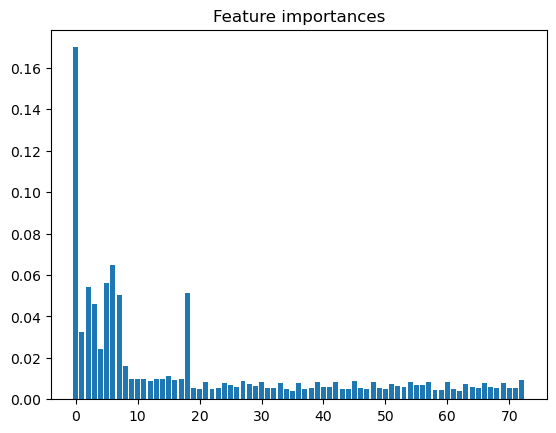

In [38]:
# Plot the feature importances of the forest
features = x.columns
plt.figure()
plt.title("Feature importances")
plt.bar (indices, importances)
plt.show()

In [39]:
#Max importance
max_importance = 0

for i in range(0,len(importances)):
    if importances[i] >= importances[max_importance]:
        max_importance = i
print('Most important feature is: ' + str(x.columns[max_importance]))

Most important feature is: XLP_returns


In [40]:
#Predicted Returns for ticker of interest
clf4_predictions = clf4.predict(df_test_predictions)

predicted_returns = []

clf4_predictions = [x==1 for x in clf4_predictions]

dates_bought = x_stack_test[clf4_predictions]

for i in dates_bought.index.tolist():
    predicted_returns.append(df_forward_returns.iloc[i,:][TICKER_OF_INTEREST+'_1D_forward_returns'])


mean_predicted_returns = sum(predicted_returns) / len(predicted_returns)
print('Mean Predicted Returns: ' + str(mean_predicted_returns))


# #Per ticker returns
# print(x_stack_test[x_stack_test.columns[0:9]].mean(axis=0))

Mean Predicted Returns: -0.00017029612366284164


In [41]:
print('Mean Predicted Returns: ' + str(mean_predicted_returns))
for ticker in tickers:
    ticker_returns = []
    for i in range(x_stack_test.index[0], x_stack_test.index[-1]+1):
        ticker_returns.append(df[ticker + '_returns'].iloc[i])
  
    mean_ticker_returns = sum(ticker_returns) / len(ticker_returns)
    print(ticker + ' Returns: ' + str(mean_ticker_returns))

Mean Predicted Returns: -0.00017029612366284164
XLP Returns: 7.225100927963228e-05
XLY Returns: -0.00023688110045948365
XLE Returns: 0.0011820410098250093
XLF Returns: -4.3445442150332855e-05
XLV Returns: 4.981007042354629e-05
XLI Returns: 0.00018168253021679206
XLB Returns: 2.0058001407955512e-05
XLK Returns: 0.0003287826190878235
XLU Returns: 2.9488990393404836e-05
